In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import fiona
import os

#Import all the utilities
from utils import *

In [2]:
#Output directory
output_dir = Path('../outputs')
output_dir.mkdir(parents=True, exist_ok=True)

The Following data comes from the paper: **Nelson-Mercer, B., Kim, T., Tran, V.N. et al. Pluvial flood impacts and policyholder responses throughout the United States. npj Nat. Hazards 2, 8 (2025). https://doi.org/10.1038/s44304-025-00058-7**

In [3]:
#Directory of the National Flood Insurance Program (NFIP)data
nfip_dir = Path("../data/FinalData/Filtered_LSR_withNexgenCatchmentsgt1.csv")

In [4]:
df = pd.read_csv(nfip_dir)
df.columns

Index(['VALID', 'VALID2', 'LAT', 'LON', 'MAG', 'WFO', 'TYPECODE', 'TYPETEXT',
       'CITY', 'COUNTY', 'STATE', 'SOURCE', 'REMARK', 'UGC', 'UGCNAME',
       'QUALIFIER', 'OBJECTID', 'Join_Count', 'TARGET_FID', 'STATE_ABBR',
       'STATE_FIPS', 'COUNTY_FIPS', 'STCOFIPS', 'TRACT_FIPS', 'FIPS',
       'POPULATION', 'POP_SQMI', 'SQMI', 'POPULATION_2020', 'POP20_SQMI',
       'damagePercent', 'nextgen_catchment', 'event_date'],
      dtype='object')

In [5]:
#Boundary of hydrofabric
HF_boundary = Path('../ngiab_preprocess_output/cat-2431121/config/cat-2431121_subset.gpkg')

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def plt_nfip_data(df, start_date, end_date, boundary_path, boundary_layer="divides"):
    """
    Filter flood data using 'dateOfLoss' and plot points within a spatial boundary.

    Parameters:
        df (pd.DataFrame): Input NFIP DataFrame
        start_date (str): Start date in 'YYYY-MM-DD'
        end_date (str): End date in 'YYYY-MM-DD'
        boundary_path (str): Path to boundary file (e.g., .gpkg)
        boundary_layer (str): Layer name in geopackage (default: 'divides')
    """
    # Convert dateOfLoss to datetime.date
    df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'], format='%d-%b-%Y', errors='coerce').dt.date
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()

    # Optional: ensure causedBy100yr is numeric
    df['causedBy100yr'] = pd.to_numeric(df['causedBy100yr'], errors='coerce')

    # Filter
    df_filtered = df[
        (df['dateOfLoss'] >= start_date) &
        (df['dateOfLoss'] <= end_date) &
        (df['causedBy100yr'] == 0)
    ].dropna(subset=['latitude', 'longitude'])

    print(f"Filtered records: {len(df_filtered)}")

    if df_filtered.empty:
        print("No data matched the filter conditions.")
        return

    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df_filtered['longitude'], df_filtered['latitude'])]
    gdf_points = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

    # Load and reproject boundary
    boundary = gpd.read_file(boundary_path, layer=boundary_layer)
    boundary = boundary.to_crs("EPSG:4326")

    # Spatial filtering
    boundary_union = boundary.geometry.union_all()
    gdf_points_within = gdf_points[gdf_points.geometry.within(boundary_union)]

    if gdf_points_within.empty:
        print("No points fall within the boundary.")
        return

    # Plot
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Draw boundary first (transparent fill)
    boundary.plot(ax=ax, edgecolor='black', facecolor='none', zorder=1)
    
    # Draw points on top
    gdf_points_within.plot(ax=ax, color='blue', markersize=20, alpha=1.0, zorder=2)
    
    ax.set_title(f"NFIP Points ({start_date} to {end_date}) within Boundary")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(True)
    plt.show()


In [7]:
plt_nfip_data(
    df=df, 
    start_date="2017-08-20", 
    end_date="2017-09-01", 
    boundary_path=HF_boundary
)


Filtered records: 5681
No points fall within the boundary.


In [8]:
#filtered record
start_date="2017-08-20"
end_date="2017-09-01"

# Convert dateOfLoss to datetime.date
df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'], format='%d-%b-%Y', errors='coerce').dt.date
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# Optional: ensure causedBy100yr is numeric
df['causedBy100yr'] = pd.to_numeric(df['causedBy100yr'], errors='coerce')

# Filter
df_filtered = df[
    (df['dateOfLoss'] >= start_date) &
    (df['dateOfLoss'] <= end_date) &
    (df['causedBy100yr'] == 0)
].dropna(subset=['latitude', 'longitude'])

print(f"Filtered records: {len(df_filtered)}")

Filtered records: 5681


**Exploring the CFE results**

In [9]:
#Sample catchment file
catchment_dir = Path('../ngiab_preprocess_output/cat-2431121/outputs/ngen/cat-2431121.csv')
df = pd.read_csv(catchment_dir)
df.columns

Index(['Time Step', 'Time', 'RAIN_RATE', 'GIUH_RUNOFF', 'INFILTRATION_EXCESS',
       'DIRECT_RUNOFF', 'NASH_LATERAL_RUNOFF', 'DEEP_GW_TO_CHANNEL_FLUX',
       'SOIL_TO_GW_FLUX', 'Q_OUT', 'POTENTIAL_ET', 'ACTUAL_ET', 'GW_STORAGE',
       'SOIL_STORAGE', 'SOIL_STORAGE_CHANGE', 'SURF_RUNOFF_SCHEME',
       'NWM_PONDED_DEPTH'],
      dtype='object')

Plot saved: ../outputs/cat-2431120_timeseries.png


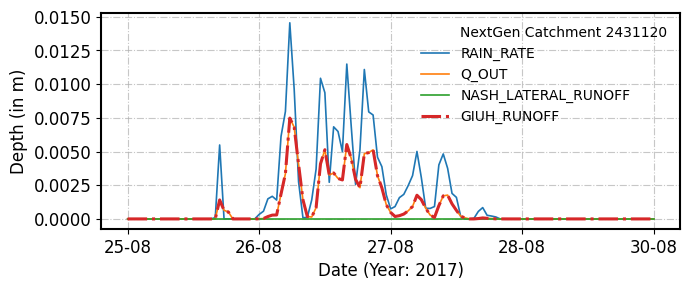

In [18]:
#plot the CFE results
plot_CFE_results(
    outletID_value = '2431121', #this is the folder ID
    cat_id = '2431120',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-08-25',
    end_time = '2017-08-30',
    output_dir = output_dir,
    variables = ['RAIN_RATE','Q_OUT', 'NASH_LATERAL_RUNOFF','GIUH_RUNOFF']
)

Plot saved: ../outputs/cat-2431120_timeseries.png


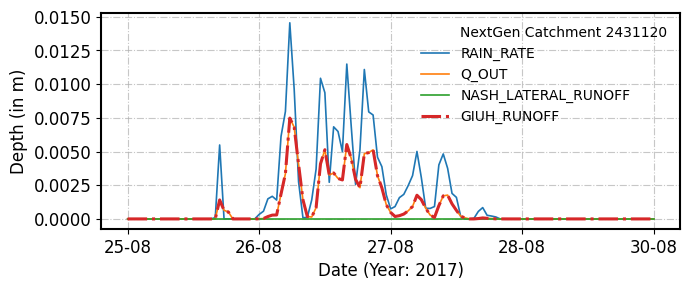

In [20]:
#plot the CFE results
plot_CFE_results(
    outletID_value = '2431121', #this is the folder ID
    cat_id = '2431120',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-08-25',
    end_time = '2017-08-30',
    output_dir = output_dir,
    variables = ['RAIN_RATE','Q_OUT', 'NASH_LATERAL_RUNOFF','GIUH_RUNOFF']
)

Plot saved: ../outputs/cat-2408004_timeseries.png


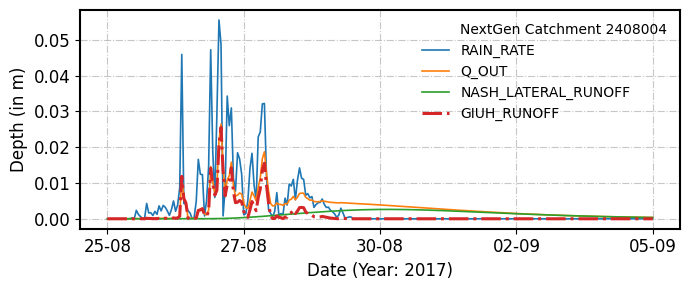

In [65]:
#plot the CFE results
plot_CFE_results(
    outletID_value = '2408020', #this is the folder ID
    cat_id = '2408004',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-08-25',
    end_time = '2017-09-05',
    output_dir = output_dir,
    variables = ['RAIN_RATE','Q_OUT', 'NASH_LATERAL_RUNOFF','GIUH_RUNOFF']
)

Plot saved: ../outputs/cat-2436875_timeseries.png


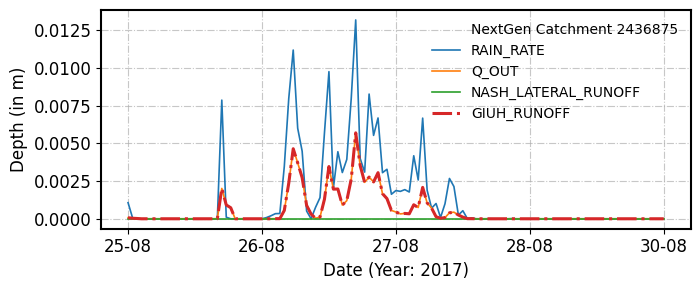

In [28]:
#Just for the vegetated catchment
#plot the CFE results
plot_CFE_results(
    outletID_value = '2436877', #this is the folder ID
    cat_id = '2436875',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-08-25',
    end_time = '2017-08-30',
    output_dir = output_dir,
    variables = ['RAIN_RATE','Q_OUT', 'NASH_LATERAL_RUNOFF','GIUH_RUNOFF']
)

**LSR event data and CFE simulations together**

In [39]:
def plot_CFE_with_LSR(
    outletID_value,
    cat_id,
    id_type,
    start_time,
    end_time,
    variables,
    output_dir,
    storm_csv_path,
    base_dir='../ngiab_preprocess_output',
    rounded_time = None
):
    import pandas as pd
    import geopandas as gpd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from shapely.geometry import Point
    from pathlib import Path

    id_str = f"{id_type}-{outletID_value}"
    ID = f"cat-{cat_id}"

    geopackage_path = Path(base_dir) / id_str / 'config' / f"{id_str}_subset.gpkg"
    csv_path = Path(base_dir) / id_str / 'outputs' / 'ngen' / f"{ID}.csv"

    if not csv_path.exists():
        print(f"Hydro CSV not found: {csv_path}")
        return

    # Load and filter boundary
    divides_gdf = gpd.read_file(geopackage_path, layer='divides').to_crs(epsg=4326)
    catchment_boundary = divides_gdf[divides_gdf['divide_id'] == f'cat-{cat_id}']

    if catchment_boundary.empty:
        print(f"No boundary found for divide_id = cat-{cat_id}")
        return

    # Load and clip storm data
    storm_df = pd.read_csv(storm_csv_path, parse_dates=['VALID2'])
    storm_gdf = gpd.GeoDataFrame(
        storm_df,
        geometry=gpd.points_from_xy(storm_df['LON'], storm_df['LAT']),
        crs='EPSG:4326'
    )
    storm_clipped = gpd.sjoin(storm_gdf, catchment_boundary, predicate='within', how='inner')

    # Filter storm events by time
    start_time = pd.to_datetime(start_time)
    event_time_str = str(rounded_time)
    end_time = pd.to_datetime(end_time)
    storm_filtered = storm_clipped[
        (storm_clipped['VALID2'] >= start_time) & (storm_clipped['VALID2'] <= end_time)
    ]

    # Load hydro output
    df = pd.read_csv(csv_path, parse_dates=['Time'])
    df['Time'] = pd.to_datetime(df['Time'])
    df_filtered = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]

    if df_filtered.empty:
        print(f"No hydro data in selected time range for {id_str}")
        return

    # Plotting
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 2.5))
    handles, labels = [], []

    for var in variables:
        if var in df_filtered.columns:
            linewidth = 3 if var == 'GIUH_RUNOFF' else 2
            linestyle = '-.' if var == 'GIUH_RUNOFF' else '-'
            line, = ax.plot(df_filtered['Time'], df_filtered[var],
                            label=var, linestyle=linestyle, linewidth=linewidth)
            handles.append(line)
            labels.append(var)
        else:
            print(f"Variable '{var}' not found in {ID}.csv")

    if not storm_filtered.empty:
        ax.scatter(
            storm_filtered['VALID2'],
            np.full(len(storm_filtered), ax.get_ylim()[1] * 0.3),
            facecolor='fuchsia', edgecolor='blue', alpha=0.7,
            marker='o', s=50, label='Storm Event (LSR)', zorder=5
        )

    # Axis formatting
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Depth (m)', fontsize=14)

    # Set explicit y-axis ticks
    ax.set_yticks([0, 0.02, 0.04])

    # Format x-axis ticks: exactly 4 ticks, rounded to nearest hour
    start = df_filtered['Time'].iloc[0].floor('H')
    end = df_filtered['Time'].iloc[-1].ceil('H')
    x_ticks = pd.date_range(start=start, end=end, periods=3)
    ax.set_xticks(x_ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

    # Increase tick label size
    ax.tick_params(axis='both', labelsize=12)

    # Year text inside plot (no border)
    ax.text(0.98, 0.95, f'Year: {start_time.year}',
            transform=ax.transAxes, fontsize=12, 
            verticalalignment='top', horizontalalignment='right')

    # Thicken plot border
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Save
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    suffix = f"_{event_time_str}" if event_time_str else ""
    save_path = output_dir / f"{ID}_storm_overlay_simple{suffix}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=500)
    print(f"Plot saved: {save_path}")
    plt.show()


In [40]:
def plot_CFE_for_single_catchment(
    cat_id,
    id_type,
    variables,
    output_dir,
    LSR_csvdir,
    base_dir='../ngiab_preprocess_output'
):
    import pandas as pd
    from tqdm import tqdm

    # Load the LSR event CSV with columns: nextgen_catchment, VALID2
    event_df = pd.read_csv(LSR_csvdir, parse_dates=['VALID2'])
    event_df = event_df.dropna(subset=['nextgen_catchment', 'VALID2'])

    # Filter only rows matching the given catchment ID (formatted as cat-<ID>)
    matched = event_df[event_df['nextgen_catchment'].astype(str) == f"cat-{cat_id}"]

    if matched.empty:
        print(f"No events found for catchment {cat_id} in LSR CSV")
        return

    # Loop through matched rows
    for _, row in tqdm(matched.iterrows(), total=len(matched), desc=f"Processing cat-{cat_id}"):
        rounded_time = row['VALID2'].ceil('H')
        start_time = (rounded_time - pd.Timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S')
        end_time = (rounded_time + pd.Timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S')

        plot_CFE_with_LSR(
            outletID_value=cat_id,
            cat_id=cat_id,
            id_type = id_type,
            start_time=start_time,
            end_time=end_time,
            variables=variables,
            output_dir=output_dir,
            storm_csv_path=LSR_csvdir,
            base_dir=base_dir,
            rounded_time = rounded_time
        )

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2008-06-12 23:00:00.png


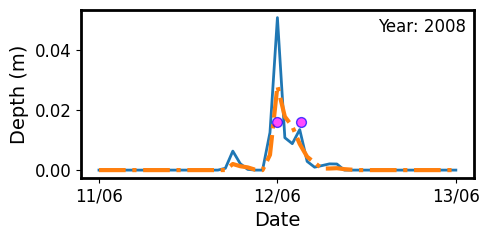

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2008-06-13 03:00:00.png


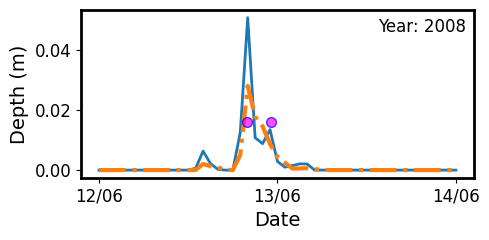

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2010-07-14 23:00:00.png


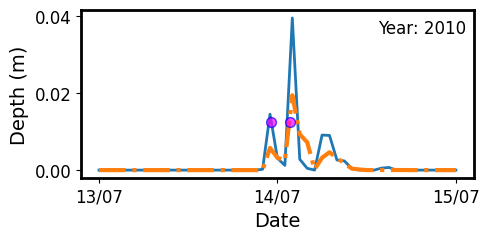

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2010-07-15 01:00:00.png


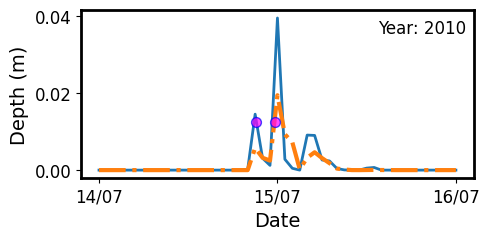

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2012-05-03 13:00:00.png


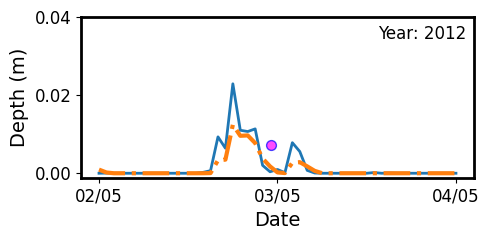

/tmp/ipykernel_416/3054523507.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rounded_time = row['VALID2'].ceil('H')
/tmp/ipykernel_416/2551536368.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df_filtered['Time'].iloc[0].floor('H')
/tmp/ipykernel_416/2551536368.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end = df_filtered['Time'].iloc[-1].ceil('H')


Plot saved: ../outputs/cat-655183_storm_overlay_simple_2021-07-15 13:00:00.png


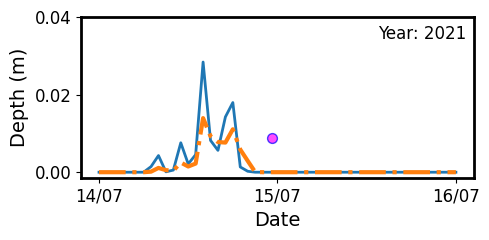

Processing cat-655183: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


In [41]:
#Plotting for new catchment and evnet
plot_CFE_for_single_catchment(
    cat_id = '655183',
    id_type = 'cat',
    variables = ['RAIN_RATE', 'GIUH_RUNOFF'],
    output_dir = "../outputs",
    LSR_csvdir=nfip_dir,
    base_dir='../ngiab_preprocess_output'
)

In [8]:
# #plot the CFE results
# plot_CFE_with_LSR(
#     outletID_value = '2436877', #this is the folder ID
#     cat_id = '2436882',
#     id_type = 'cat', #cat for catchmet and gage for gage id
#     start_time = '2017-03-20',
#     end_time = '2017-05-20',
#     output_dir = output_dir,
#     variables = ['RAIN_RATE','GIUH_RUNOFF'],
#     storm_csv_path = LSR_dir
# )

Plot saved: ../outputs/cat-2436877_storm_overlay_simple.png


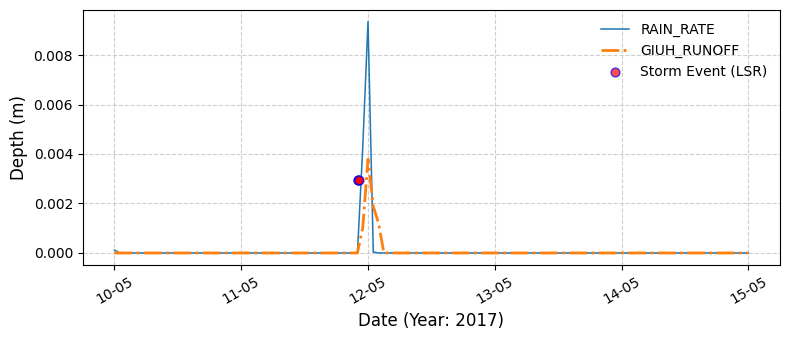

In [56]:
#plot the CFE results
plot_CFE_with_LSR(
    outletID_value = '2436877', #this is the folder ID
    cat_id = '2436877',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-05-10',
    end_time = '2017-05-15',
    output_dir = output_dir,
    variables = ['RAIN_RATE', 'GIUH_RUNOFF',],
    storm_csv_path = LSR_dir
)

Plot saved: ../outputs/cat-2436875_storm_overlay_simple.png


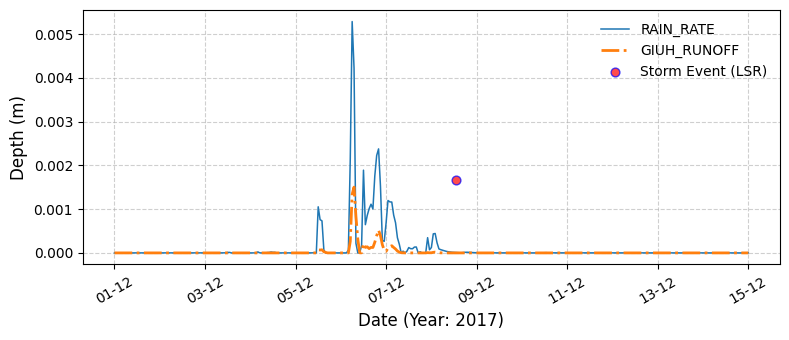

In [61]:
#plot the CFE results
plot_CFE_with_LSR(
    outletID_value = '2436877', #this is the folder ID
    cat_id = '2436875',
    id_type = 'cat', #cat for catchmet and gage for gage id
    start_time = '2017-12-01',
    end_time = '2017-12-15',
    output_dir = output_dir,
    variables = ['RAIN_RATE', 'GIUH_RUNOFF',],
    storm_csv_path = LSR_dir
)